In [65]:
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set up

In [66]:
# set up auto load
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
from load_data import *
from model import *

plt.rcParams['font.family'] = 'serif'
sns.set_style("darkgrid")

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print('PyTorch CUDA is available?', torch.cuda.is_available())

PyTorch CUDA is available? True


In [68]:
train_ticker_strings = ["AAPL", "AMZN", "CAT", "GOOG", "HSBC", "KO", "JPM", "PCG", "ABB", "BAC", "BP"]
# train_ticker_strings = ["GOOG", "T", "ORCL", "TSM", "VZ", "INTC", "CSCO"]
look_back = 60
train_data_loader = get_data_loader(TransformerMultiFeaturesDataset, train_ticker_strings, look_back=look_back)
print("train data size (in batches):", len(train_data_loader))

train data size (in batches): 412


In [69]:
train_small_data_loader = get_data_loader(TransformerMultiFeaturesDataset, train_ticker_strings[:1], look_back=look_back)
print("train small data size (in batches):", len(train_small_data_loader))

train small data size (in batches): 38


In [70]:
input_dim = 4
hidden_dim = 256
num_layers = 6
output_dim = 1
num_epochs = 50
lr = 0.01
dim_feedforward = 1024
nhead = 2
dropout=0.1
hist = np.zeros(num_epochs)

model = Transformer(
    look_back,
    input_dim,
    hidden_dim=hidden_dim,
    dim_feedforward=dim_feedforward,
    nhead=nhead,
    num_encoder_layers=num_layers,
    dropout=dropout,
    device=device
)
model = model.to(device)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

Transformer(
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (multi_head): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (layer_norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (layer_norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=4, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=4, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (cross_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (layer_norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=4, out_features=256, bias=True)
  (relu): ReLU()
 

In [71]:
# try model on small dataset
for t in range(num_epochs):
    total_loss = 0
    # y_train_preds = []
    for X_train, y_train in train_small_data_loader:
        X_train = X_train.to(device)

        # Forward pass
        y_train_pred = model(X_train)
        # y_train_preds.extend(y_train_pred)

        loss = loss_fn(y_train_pred, y_train.to(device))

        total_loss += loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()

    hist[t] = total_loss
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", total_loss)

Epoch  10 MSE:  57.13573098182678
Epoch  20 MSE:  51.444055676460266
Epoch  30 MSE:  47.90578079223633
Epoch  40 MSE:  49.05895611643791


In [72]:
input_dim = 4
hidden_dim = 256
num_layers = 6
output_dim = 1
num_epochs = 300
lr = 0.001
dim_feedforward = 1024
nhead = 2
dropout=0.1
hist = np.zeros(num_epochs)

model = Transformer(
    look_back,
    input_dim,
    hidden_dim=hidden_dim,
    dim_feedforward=dim_feedforward,
    nhead=nhead,
    num_encoder_layers=num_layers,
    dropout=dropout,
    device=device
)
model = model.to(device)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)


# train the model
for t in range(num_epochs):
    total_loss = 0
    # y_train_preds = []
    for X_train, y_train in train_data_loader:
        X_train = X_train.to(device)

        # Forward pass
        y_train_pred = model(X_train)
        # y_train_preds.extend(y_train_pred)

        loss = loss_fn(y_train_pred, y_train.to(device))

        total_loss += loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()

    hist[t] = total_loss
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", total_loss)

Epoch  10 MSE:  570.3557366728783
Epoch  20 MSE:  543.0030945241451
Epoch  30 MSE:  533.4718278646469
Epoch  40 MSE:  525.2121177911758
Epoch  50 MSE:  520.7223873436451
Epoch  60 MSE:  517.647711277008
Epoch  70 MSE:  514.0704785585403
Epoch  80 MSE:  514.433681845665
Epoch  90 MSE:  516.7823698222637
Epoch  100 MSE:  506.2317134141922
Epoch  110 MSE:  508.97635239362717
Epoch  120 MSE:  505.71769508719444
Epoch  130 MSE:  504.5660135149956
Epoch  140 MSE:  504.228797018528
Epoch  150 MSE:  502.074722841382
Epoch  160 MSE:  500.65874060988426
Epoch  170 MSE:  500.4008463025093
Epoch  180 MSE:  507.01128646731377
Epoch  190 MSE:  500.4285134077072
Epoch  200 MSE:  502.6887565255165
Epoch  210 MSE:  501.2598437964916
Epoch  220 MSE:  502.34619960188866
Epoch  230 MSE:  502.7147218286991
Epoch  240 MSE:  498.97315004467964
Epoch  250 MSE:  498.8865783214569
Epoch  260 MSE:  503.70983627438545
Epoch  270 MSE:  497.10635900497437
Epoch  280 MSE:  501.66544675827026
Epoch  290 MSE:  498.047

Text(0.5, 1.0, 'Loss')

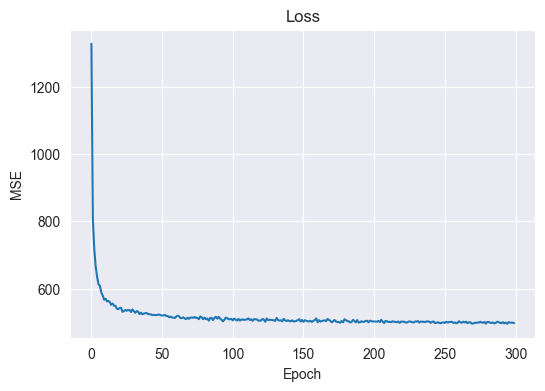

In [79]:
figure, axes = plt.subplots(figsize=(6, 4))
plt.plot(range(num_epochs), hist)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Loss")

In [80]:
test_ticker_string = ['MSFT']
test_data_loader = get_data_loader(TransformerMultiFeaturesDataset, test_ticker_string, look_back=look_back, shuffle=False, train=False)
predicted_ticker = test_ticker_string[0]
print("test data sze (in batches):", len(test_data_loader))

test data sze (in batches): 38


In [81]:
# make predictions
y_tests = []
y_test_preds = []
for X_test, y_test in test_data_loader:
    X_test = X_test.to(device)
    y_tests.extend(y_test)
    pred = model(X_test)
    pred = pred.detach().cpu()
    y_test_preds.extend(pred)

# y_tests = test_data_loader.dataset.df['Adj Close'][look_back:].values
y_tests = torch.stack(y_tests).cpu().detach().numpy()
y_test_preds = torch.stack(y_test_preds).cpu().detach().numpy()

# calculate root mean squared error
testScore = (mean_squared_error(y_tests, y_test_preds))
print('Test Score: %.5f MSE' % (testScore))

y_tests = test_data_loader.dataset.df['Adj Close']
y_tests = np.array(y_tests)
# N, 1 -> N, 1, D
y_test_preds = np.expand_dims(y_test_preds, axis=2).repeat(input_dim, axis=2)
# N, 1
y_test_preds = test_data_loader.dataset.invert_transform(y_test_preds)
test_price_score = np.sqrt(mean_squared_error(y_tests, y_test_preds))
print('Test Price Score: %.2f RMSE' % (test_price_score))

Test Score: 1.54570 MSE
Test Price Score: 0.63 RMSE


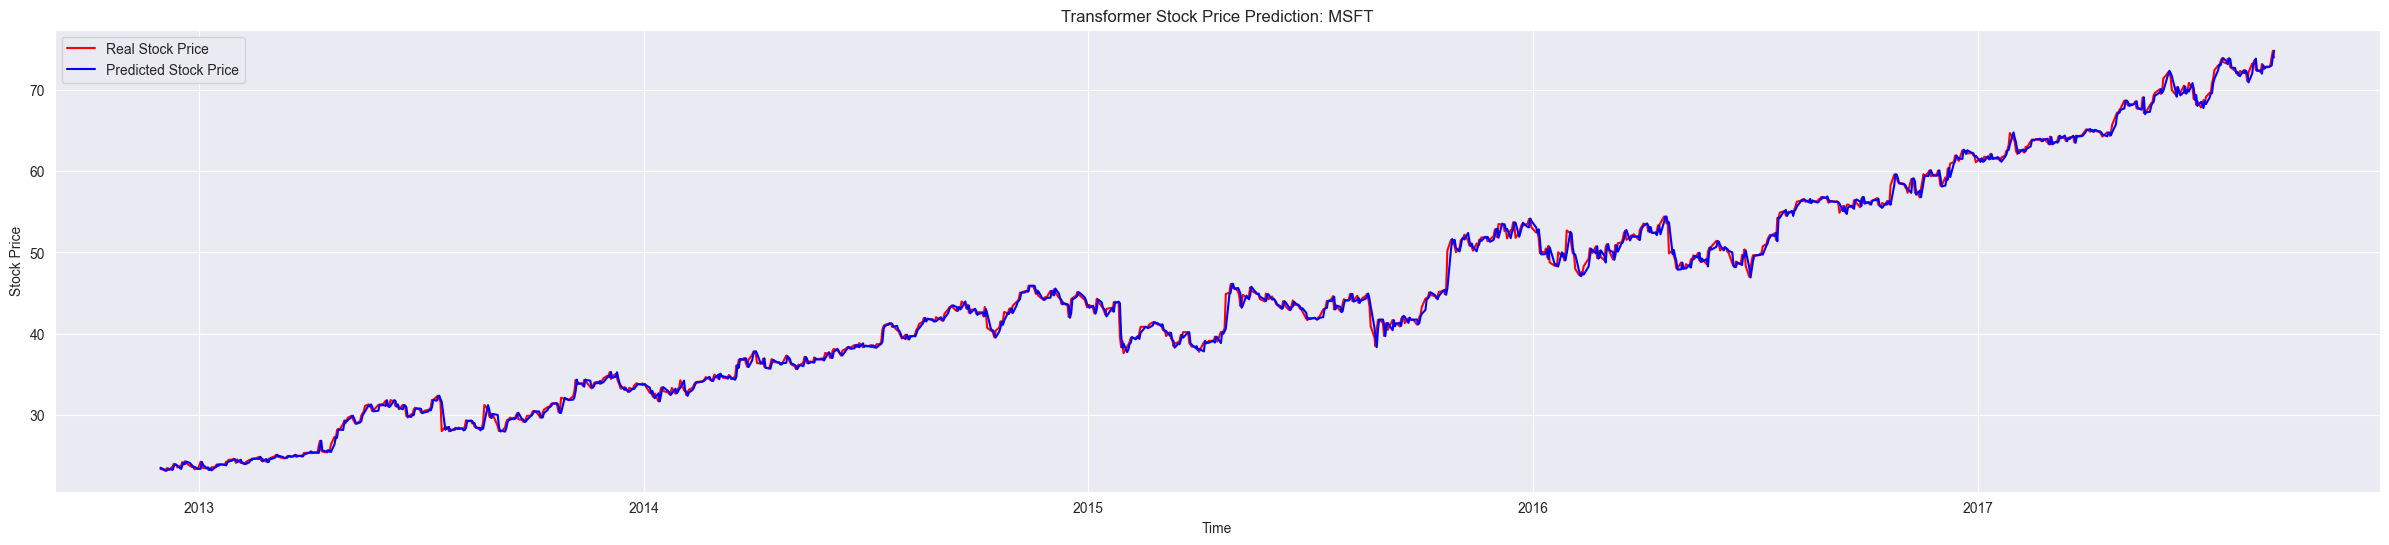

In [82]:
# Visualising the results
figure, axes = plt.subplots(figsize=(30, 6))
axes.xaxis_date()

df = test_data_loader.dataset.df

axes.plot(df.index, y_tests, color = 'red', label = 'Real Stock Price')
axes.plot(df.index, y_test_preds[:,0], color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title(f'Transformer Stock Price Prediction: {predicted_ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig(f'./plots/transformer_baseline1_pred_{predicted_ticker}.png')
plt.show()

In [83]:
correct_pred = 0
incorrect_pred = 0
for i in range(1, len(y_tests)):
    if (y_tests[i] - y_tests[i-1]) * (y_test_preds[i] - y_tests[i-1]) > 0:
        correct_pred += 1
    else:
        incorrect_pred += 1

print("Accuracy of predicting rise/drop: ", correct_pred / (correct_pred + incorrect_pred))

Accuracy of predicting rise/drop:  0.47869674185463656


In [78]:
# save_path = './models/transformer_multifeatures_model.pth'

# Save the model to file
# torch.save(model.state_dict(), save_path)